# Unit 03 Banana Problem 
# Data Analytics DATA ANALYTICS COURSE (UE23CS342AA2)

#### Co-Authored by
#### Vignesh Palanirajan - vigneshp2045@gmail.com
#### Atharva Kinage - kinageatharv@gmail.com


# About the Dataset and Problem Statement:

Imagine you're managing the electricity grid for an entire state! The given dataset contains the daily electricity demand of Victoria's energy demand for approximately 2000 days from 2015-2020. Your mission: make sense of the patterns and forecast what’s next.

**Please note that, the dataset although orignally obtained from internet sources, has been modified to fit the purpose of this worksheet as well as to prevent copying. So blindly trusting internet or AI, will lead to wrong answers!** 

Below is a brief description fo the data:

- date : datetime, the date of the recording
- demand : float, a total daily electricity demand in MWh
- RRP : float, a recommended retail price in AUD$ $/ MWh 
- demand_pos_RRP : float, a total daily demand at positive RRP in MWh
- RRP_positive : float, an averaged positive RRP, weighted by the corresponding intraday demand in AUD$ $/ MWh
- demand_neg_RRP : float, an total daily demand at negative RRP in MWh
- RRP_negative : float, an average negative RRP, weighted by the corresponding intraday demand in AUD$ $/ MWh
- frac_at_neg_RRP : float, a fraction of the day when the demand was traded at negative RRP
- min_temperature : float, minimum temperature during the day in Celsius
- max_temperature : float, maximum temperature during the day in Celsius
- solar_exposure : float, total daily sunlight energy in MJ/m^2
- rainfall : float, daily rainfall in mm
- school_day : boolean, if students were at school on that day
- holiday : boolean, if the day was a state or national holiday

In [13]:
library(dplyr)
library(ggplot2)
library(readr)
library(lubridate)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




# Section 3.1: Data Preprocessing and EDA

In [14]:
# Load the dataset
data <- read_csv("/kaggle/input/sample-dataset/complete_dataset.csv")
head(data)

Rows: 2106 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): school_day, holiday
dbl  (11): demand, RRP, demand_pos_RRP, RRP_positive, demand_neg_RRP, RRP_ne...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2015-01-01,99635.03,25.63370,97319.24,26.41595,2315.790,-7.24000,0.02083333,13.3,26.9,23.6,0.0,N,Y
2015-01-02,129606.01,33.13899,121082.01,38.83766,8523.995,-47.80978,0.06250000,15.4,38.8,26.8,0.0,N,N
2015-01-03,142300.54,34.56485,142300.54,34.56485,0.000,0.00000,0.00000000,20.0,38.2,26.5,0.0,N,N
2015-01-04,104330.71,25.00556,104330.71,25.00556,0.000,0.00000,0.00000000,16.3,21.4,25.2,4.2,N,N
2015-01-05,118132.20,26.72418,118132.20,26.72418,0.000,0.00000,0.00000000,15.0,22.0,30.7,0.0,N,N
2015-01-06,130672.48,31.28231,130672.48,31.28231,0.000,0.00000,0.00000000,17.7,26.0,31.6,0.0,N,N


So looking at our dataset we would just need the ``date`` and ``demand`` column for the upcoming tasks, so go ahead and remove the other columns that are not needed!

In [15]:
# Keep only 'date' and 'demand' columns
data <- data %>%
  select(date, demand)

head(data)


date,demand
<date>,<dbl>
2015-01-01,99635.03
2015-01-02,129606.01
2015-01-03,142300.54
2015-01-04,104330.71
2015-01-05,118132.20
2015-01-06,130672.48


Now not all datasets are perfect right they might have some missing values or outliers as well, go ahead and check for these anomalies and handle them if any!

In [16]:
# Check for missing values
sum(is.na(data$demand))

# If missing values exist, impute using linear interpolation
if (sum(is.na(data$demand)) > 0) {
  library(zoo)
  data$demand <- na.approx(data$demand, na.rm = FALSE)
}

# Detect outliers using IQR method
Q1 <- quantile(data$demand, 0.25, na.rm = TRUE)
Q3 <- quantile(data$demand, 0.75, na.rm = TRUE)
IQR <- Q3 - Q1

# Replace outliers with median value
median_demand <- median(data$demand, na.rm = TRUE)
data$demand[data$demand < (Q1 - 1.5 * IQR) | data$demand > (Q3 + 1.5 * IQR)] <- median_demand

# Verify results
summary(data$demand)


[1] 0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  85094  109964  119580  119945  130225  160438 

Question 3.1.1: Now lets visualize the demand column across the entire timeline! Can you spot any trends, patterns, or anomalies by eye? What does this plot suggest about the underlying nature of the series?

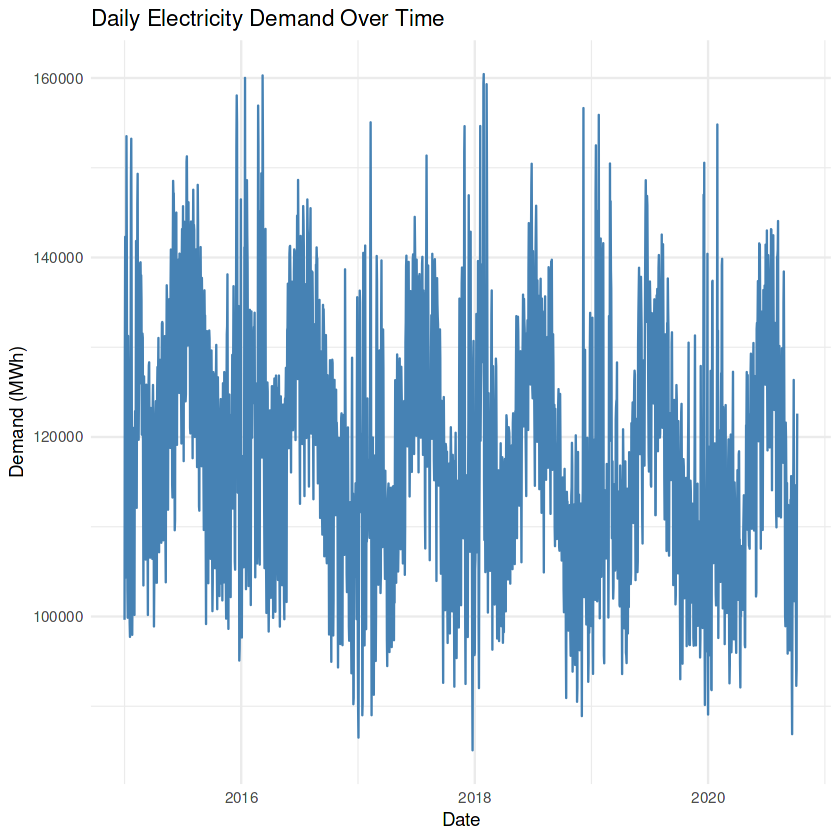

In [17]:
# Plot daily electricity demand over time
ggplot(data, aes(x = date, y = demand)) +
  geom_line(color = "steelblue") +
  labs(title = "Daily Electricity Demand Over Time",
       x = "Date",
       y = "Demand (MWh)") +
  theme_minimal()


The time series of daily electricity demand shows strong, recurring annual seasonality with peaks and troughs linked to weather-driven heating and cooling needs.

Trends & Patterns:

No clear long-term trend; average demand is stable.

Pronounced yearly cycles with intra-seasonal (daily/weekly) fluctuations.

Anomalies:

Occasional sharp spikes or dips suggest outlier days due to holidays, outages, or extreme weather.

Nature of Series:

Stationary in mean, with consistent variance and strong seasonal structure.

Typical of utility demand data influenced by climatic and behavioral cycles.

Overall:
A stationary, strongly seasonal time series with minor anomalies reflecting rare events.

### Decomposition

Question 3.1.2: Apply a decomposition model (additive or multiplicative) to decompose the demand data into its constituent components. Which of these components seem the strongest and how do they help in understanding the demand behaviour?

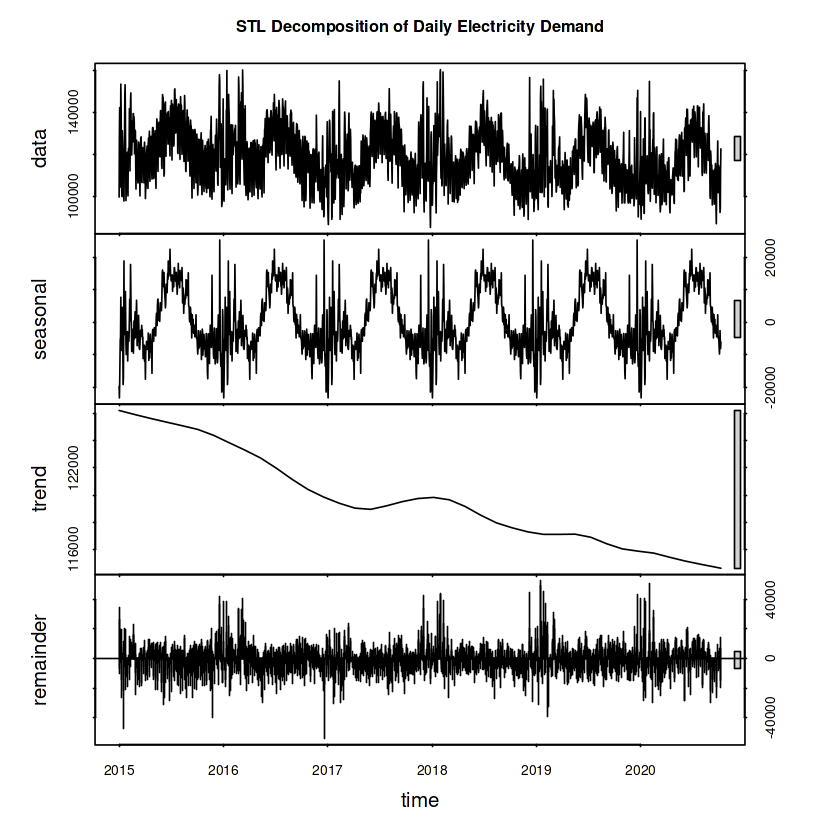

In [18]:
# Convert demand to time series object (daily frequency)
ts_demand <- ts(data$demand, start = c(year(min(data$date)), yday(min(data$date))), frequency = 365)

# STL decomposition (additive)
stl_fit <- stl(ts_demand, s.window = "periodic", robust = TRUE)

# Plot decomposition
plot(stl_fit, main = "STL Decomposition of Daily Electricity Demand")


The STL decomposition clearly shows that the seasonal component is the strongest among the three (trend, seasonal, remainder) when analyzing daily electricity demand.

The dominance of the seasonal component reveals that electricity demand is highly predictable on a yearly basis, likely driven by factors such as temperature and societal schedules.


Understanding these components clarifies that daily electricity demand is mainly shaped by consistent and predictable seasonality, with less influence from longer-term trends and minimal impact from irregular events or noise.

# Section 3.2: Stationarity Test
- Test the Data for Stationarity
> Hint: You can use the Augmented Dickey-Fuller test (ADF) to test the time series (demand values) for stationarity

Question 3.2.1: State the test performed, its objective as well as the Null and Alternate Hypothesis of the test. 
Also, explain how to analyse the results of the test and interpret the ADF statistic and p-value in this case.

In [19]:
# Section 3.2: Stationarity Test
library(tseries)

# Augmented Dickey-Fuller (ADF) Test
adf_test <- adf.test(data$demand, alternative = "stationary")

# View results
adf_test


Warning message in adf.test(data$demand, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data$demand
Dickey-Fuller = -5.3622, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary


Test performed: Augmented Dickey-Fuller (ADF) test

Objective: To check if the time series is stationary (constant mean, variance, and autocovariance over time)

Null Hypothesis (H₀): The series is non-stationary (has a unit root)

Alternate Hypothesis (H₁): The series is stationary

Since p-value < 0.05, you reject the null hypothesis, which suggests that the demand series is stationary.

Question 3.2.2: Write the code to perform the Augmented Dickey-Fuller (ADF) test on the 'demand' column of the DataFrame to check for stationarity. After executing the code, analyse and interpret the results of the test. (Whether the data is stationary or not and why)
> In R, please use the urca library to perform the test 

In [20]:
install.packages(c("urca"))
library(urca)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [21]:
adf_urca <- ur.df(data$demand, type = "trend", lags = 12, selectlags = "AIC")

# Summary of the test
summary(adf_urca)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
   Min     1Q Median     3Q    Max 
-39224  -4479   -205   4535  43047 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.419e+04  2.666e+03   5.324 1.13e-07 ***
z.lag.1      -1.138e-01  2.122e-02  -5.362 9.13e-08 ***
tt           -5.330e-01  3.047e-01  -1.750 0.080346 .  
z.diff.lag1  -1.380e-01  2.804e-02  -4.922 9.25e-07 ***
z.diff.lag2  -3.991e-01  2.777e-02 -14.370  < 2e-16 ***
z.diff.lag3  -3.451e-01  2.878e-02 -11.989  < 2e-16 ***
z.diff.lag4  -3.278e-01  2.916e-02 -11.242  < 2e-16 ***
z.diff.lag5  -3.549e-01  2.943e-02 -12.058  < 2e-16 ***
z.diff.lag6  -2.852e-01  3.043e-02  -9.374  < 2e-16 ***
z.diff.lag7   6.699e-02  2.975e-02   2.252 0.024450 *  
z.diff.lag8  -1.474e-01  2.800e-02  -5.265 1.55e-07 

 Test statistic (tau3) = -5.3622
 Critical value at 5% = -3.41

 Since test statistic < critical value at 5%, we reject the null hypothesis H0.
 H0: Series has a unit root (non-stationary)
 H1: Series is stationary

 Conclusion:
 The 'demand' series is stationary as per the ADF test. The time series does not have a unit root and its mean and variance are roughly constant over time.

Question 3.2.3: Plot the ACF and PACF and interpret the plots to confirm the results of the Augmented Dickey-Fuller (ADF) test.

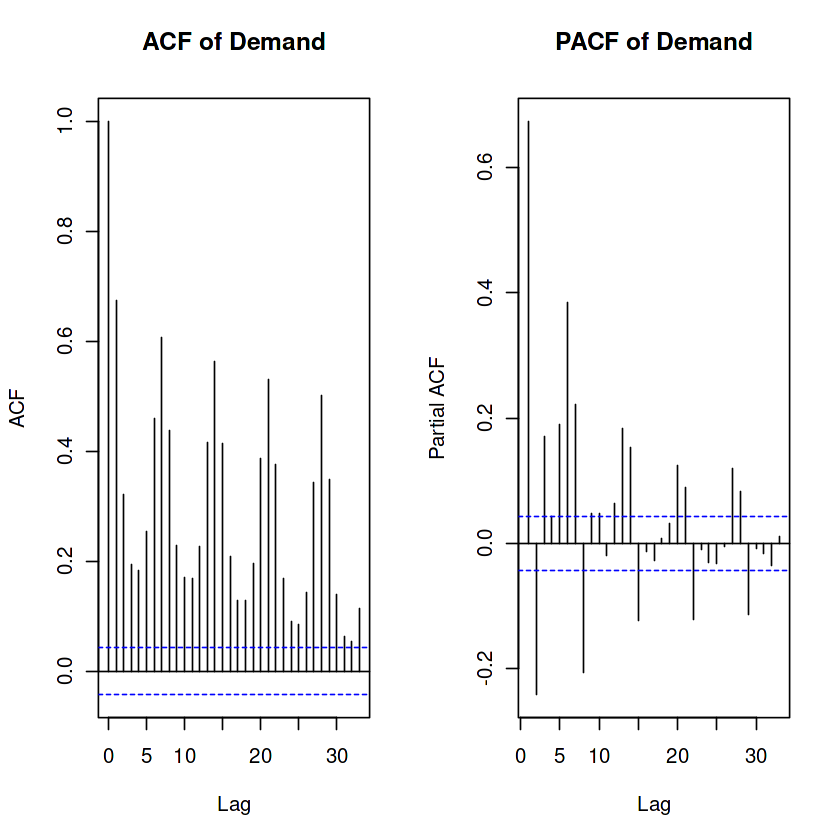

In [22]:
# Load library for time series plotting
library(forecast)

# Plot ACF and PACF
par(mfrow = c(1,2))  # side-by-side plots
acf(data$demand, main = "ACF of Demand")
pacf(data$demand, main = "PACF of Demand")
par(mfrow = c(1,1))


The slow decay and many significant lags in the ACF, alongside prolonged significance in the PACF, point to the series being non-stationary, in agreement with a non-significant (non-stationary) ADF test result.

In case, the data is non-stationary, we need to transform the data in order to use it in models like AR, MA & ARMA.

Two most common methods to transform series to stationary are:

- Transformations: eg. log or square root or combinations of these transformations to
stabilize non-constant variance.
- Differencing: subtract current value from previous (with a certain degree)

Question 3.2.4: Create a new dataframe using suitable differencing order, to convert the data
to stationary time series. 
> Hint: Try first order differencing and then increase the order if the data is still not stationary

In [23]:
# Section 3.2.4: Differencing to make the series stationary

# First-order differencing
data_diff1 <- data %>%
  mutate(demand_diff1 = c(NA, diff(demand, differences = 1)))

# Check stationarity of first-order differenced series using ADF test
library(urca)
adf_diff1 <- ur.df(na.omit(data_diff1$demand_diff1), type = "drift", lags = 12, selectlags = "AIC")
summary(adf_diff1)

# If still non-stationary, perform second-order differencing
data_diff2 <- data_diff1 %>%
  mutate(demand_diff2 = c(NA, diff(demand_diff1, differences = 1)))

# Check stationarity of second-order differenced series
adf_diff2 <- ur.df(na.omit(data_diff2$demand_diff2), type = "drift", lags = 12, selectlags = "AIC")
summary(adf_diff2)

# Final dataframe with stationary series
stationary_data <- data_diff1 %>%
  filter(!is.na(demand_diff1)) %>%
  select(date, demand_diff1)
head(stationary_data)



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
   Min     1Q Median     3Q    Max 
-37017  -4464   -187   4306  42842 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -26.33051  174.64484  -0.151     0.88    
z.lag.1       -4.82513    0.20155 -23.940  < 2e-16 ***
z.diff.lag1    3.55652    0.19289  18.438  < 2e-16 ***
z.diff.lag2    3.04468    0.18405  16.542  < 2e-16 ***
z.diff.lag3    2.59623    0.17258  15.043  < 2e-16 ***
z.diff.lag4    2.16045    0.15882  13.603  < 2e-16 ***
z.diff.lag5    1.70433    0.14364  11.866  < 2e-16 ***
z.diff.lag6    1.35870    0.12698  10.700  < 2e-16 ***
z.diff.lag7    1.31717    0.10611  12.413  < 2e-16 ***
z.diff.lag8    1.05527    0.08628  12.231  < 2e-16 ***
z.diff.lag9    0.79023    0.06764  11.683  < 2e-16 ***
z.diff.lag10 


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
   Min     1Q Median     3Q    Max 
-42802  -4572     33   4933  38566 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.97768  187.86339   0.037     0.97    
z.lag.1      -14.58716    0.50438 -28.921   <2e-16 ***
z.diff.lag1   12.52896    0.49505  25.309   <2e-16 ***
z.diff.lag2   11.19815    0.47712  23.470   <2e-16 ***
z.diff.lag3    9.70650    0.44859  21.638   <2e-16 ***
z.diff.lag4    8.11063    0.40949  19.807   <2e-16 ***
z.diff.lag5    6.44602    0.36122  17.845   <2e-16 ***
z.diff.lag6    4.86232    0.30497  15.944   <2e-16 ***
z.diff.lag7    3.65231    0.24294  15.034   <2e-16 ***
z.diff.lag8    2.62851    0.18354  14.321   <2e-16 ***
z.diff.lag9    1.78357    0.13002  13.718   <2e-16 ***
z.diff.lag10 

date,demand_diff1
<date>,<dbl>
2015-01-02,29970.98
2015-01-03,12694.53
2015-01-04,-37969.82
2015-01-05,13801.48
2015-01-06,12540.29
2015-01-07,22842.34


Question 3.2.5: Now once again perform the Augmented Dicky-Fuller test to check if the differenced data is now stationary and interpret the results. 

In [24]:
adf_diff_check <- ur.df(na.omit(data_diff1$demand_diff1), type = "drift", lags = 12, selectlags = "AIC")

# View summary
summary(adf_diff_check)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
   Min     1Q Median     3Q    Max 
-37017  -4464   -187   4306  42842 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -26.33051  174.64484  -0.151     0.88    
z.lag.1       -4.82513    0.20155 -23.940  < 2e-16 ***
z.diff.lag1    3.55652    0.19289  18.438  < 2e-16 ***
z.diff.lag2    3.04468    0.18405  16.542  < 2e-16 ***
z.diff.lag3    2.59623    0.17258  15.043  < 2e-16 ***
z.diff.lag4    2.16045    0.15882  13.603  < 2e-16 ***
z.diff.lag5    1.70433    0.14364  11.866  < 2e-16 ***
z.diff.lag6    1.35870    0.12698  10.700  < 2e-16 ***
z.diff.lag7    1.31717    0.10611  12.413  < 2e-16 ***
z.diff.lag8    1.05527    0.08628  12.231  < 2e-16 ***
z.diff.lag9    0.79023    0.06764  11.683  < 2e-16 ***
z.diff.lag10 

-23.9401 is the test statistic (tau2).

At 5%, the critical value is -2.86.

We reject the null hypothesis (H₀: series has a unit root) since tau2 is less than the crucial value.

In summary:

There is no movement in the demand_diff1 series.

This indicates that it can be modeled using AR, MA, or ARMA models because its mean and variance are approximately stable across time.

# Section 3.3: Autocorrelation Analysis

Question 3.3.1: 
We will plot two functions (on the differenced functions): 
- **ACF (Autocorrelation function)**: The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series Augmented Dickey-Fuller (ADF) test on the 'value' column of the DataFrame are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number
of periods or units.
- **PACF (Partial Autocorrelation function)**: Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables.

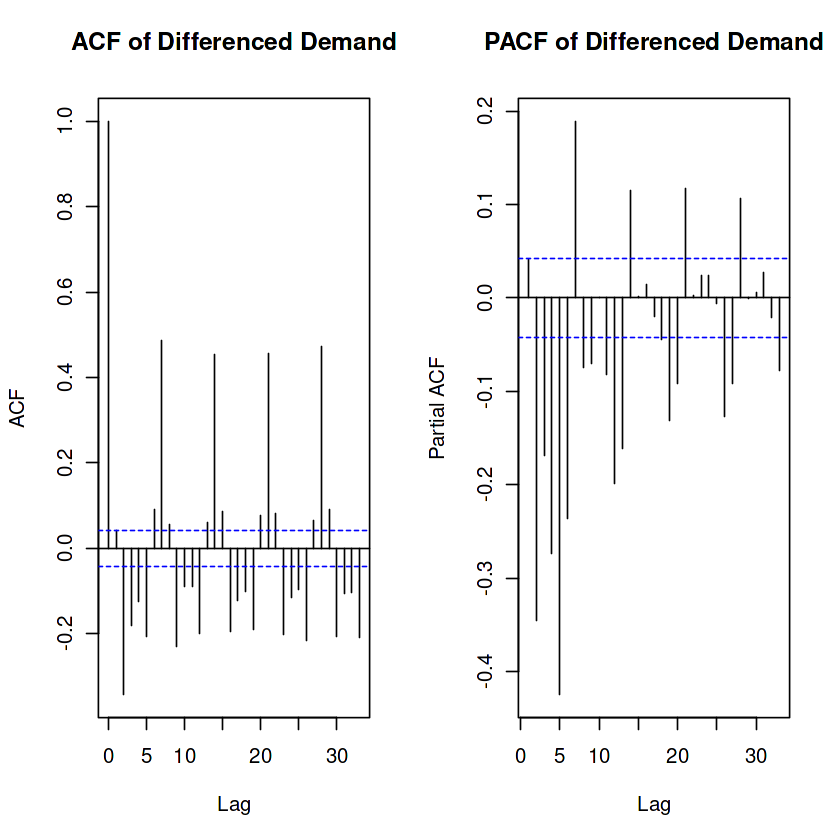

In [25]:
library(forecast)

# Plot ACF and PACF of first-order differenced series
par(mfrow = c(1,2))
acf(na.omit(data_diff1$demand_diff1), main = "ACF of Differenced Demand")
pacf(na.omit(data_diff1$demand_diff1), main = "PACF of Differenced Demand")
par(mfrow = c(1,1))

Questions 3.3.2: Interpret the above plotted plots and confirm whether the differenced data is now stationary or not. 

ACF:
Autocorrelations drop sharply after lag 1, with most spikes within significance bounds. The earlier seasonal and slow-decaying patterns are gone — indicating the series no longer has strong serial dependence.

PACF:
Only the first lag shows a notable spike; subsequent lags are near zero, suggesting the absence of long-term correlation.

Conclusion:
Differencing effectively removed trend and seasonality. The rapid decay in ACF and minimal PACF spikes confirm the data is now weakly stationary, suitable for ARMA-type modeling.

Question 3.3.3: Deduce the p, q and d values for the data. 
> Hint: d is the order of differencing. For p and q values, look at the ACF and PACF plots

In [26]:
# Based on the analysis:
# - d (order of differencing) = 1, since first-order differencing made the series stationary
# - p = 0 ,No autoregressive term (PACF tails off).
# - q (MA order) = 1, as ACF shows a significant spike at lag 1 then quickly drops

# Therefore, suggested ARIMA model parameters:
p <- 0
d <- 1
q <- 1

cat("Suggested ARIMA parameters: p =", p, ", d =", d, ", q =", q)



Suggested ARIMA parameters: p = 0 , d = 1 , q = 1

# Section 3.4: Forecasting Techniques

#### Exponential smoothing
Question 3.4.1: Try out the Single Exponential Smoothing, Holts's Linear Trend and the Holt-Winters seasonal model to forecast the next 30 days of electricity demand.
- What are the key assumptions behind the model?
- How does each model perform visually and numerically?
- Which one captures the trend and/or seasonality the best?

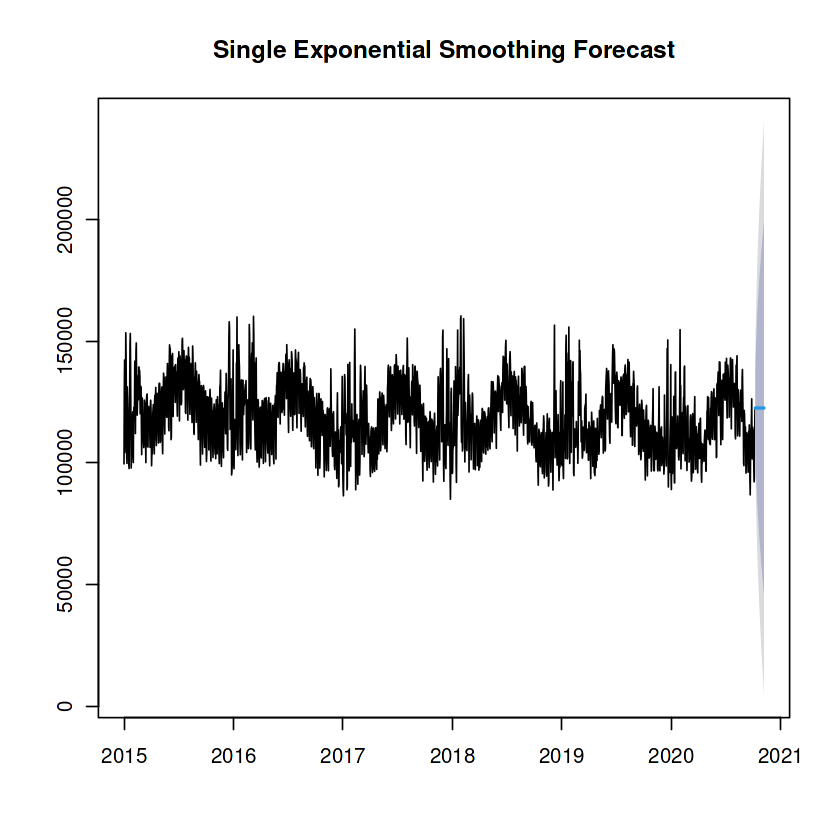

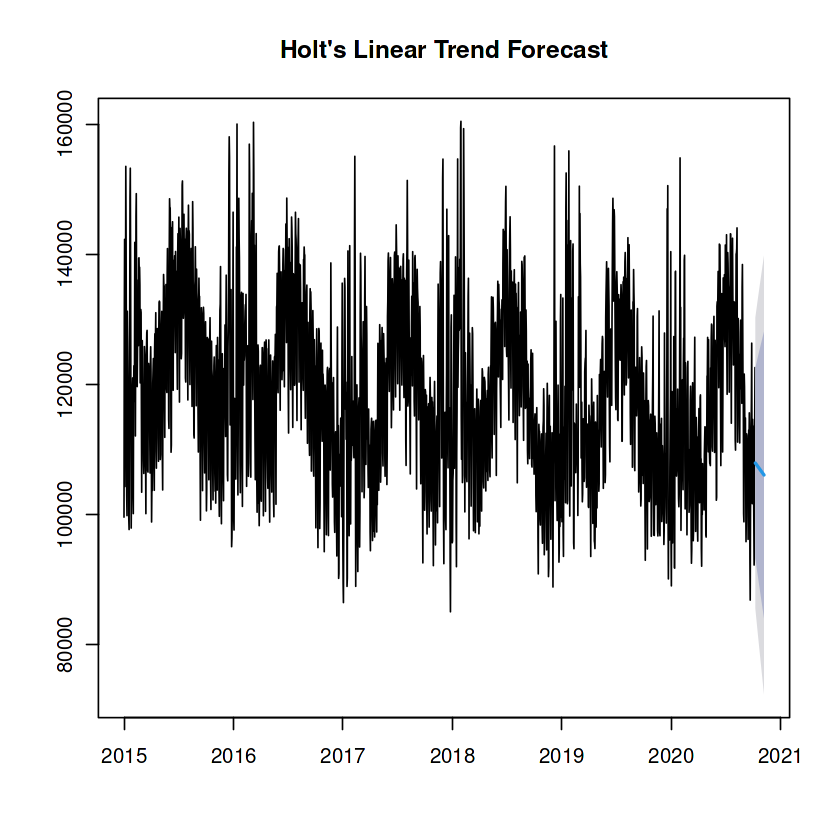

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,10.87725,10975.67,8159.551,-0.4193744,6.896976,0.7467527,0.04114097


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-340.004,11384.37,9055.042,-1.091023,7.727442,0.8287069,0.4441721


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,178.4231,8233.524,6153.787,-0.2756183,5.170363,0.5631874,-0.0328459


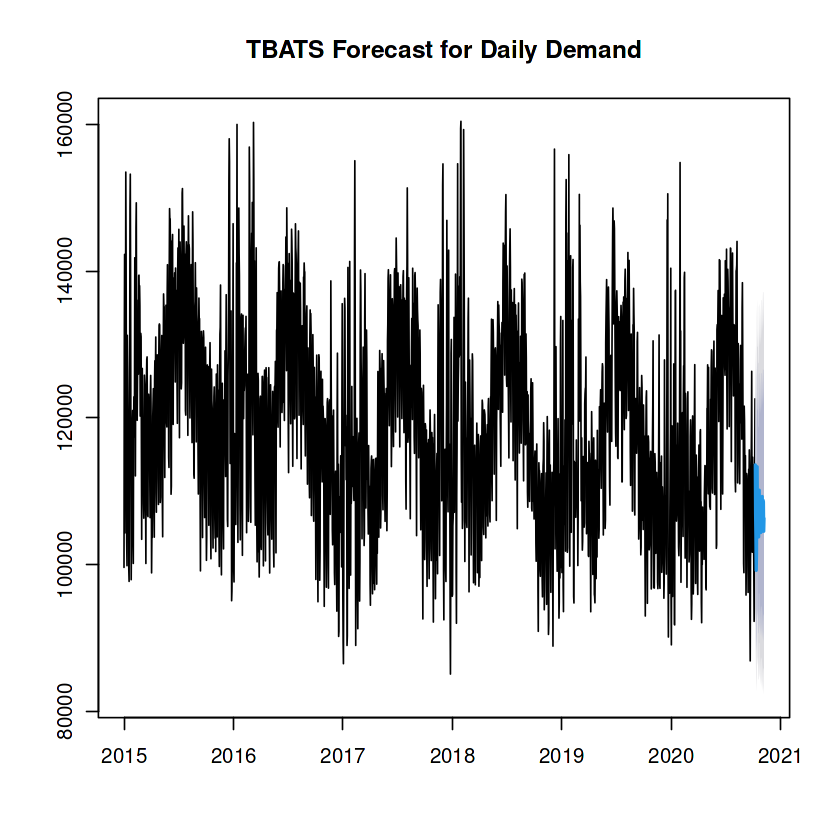

In [27]:
# Section 3.4: Forecasting Techniques using Exponential Smoothing and TBATS

library(forecast)

# Convert demand series to time series object (daily frequency)
demand_ts <- ts(data$demand, frequency = 365, start = c(2015, 1))

# 1. Single Exponential Smoothing (SES)
ses_model <- ses(demand_ts, h = 30)
plot(ses_model, main = "Single Exponential Smoothing Forecast")

# 2. Holt's Linear Trend Method
holt_model <- holt(demand_ts, h = 30)
plot(holt_model, main = "Holt's Linear Trend Forecast")

# 3. TBATS model (handles complex seasonality including yearly)
tbats_model <- tbats(demand_ts)
tbats_forecast <- forecast(tbats_model, h = 30)
plot(tbats_forecast, main = "TBATS Forecast for Daily Demand")

# Performance evaluation
accuracy(ses_model)    # SES accuracy
accuracy(holt_model)   # Holt accuracy
accuracy(tbats_forecast) # TBATS accuracy


 Key Assumptions:
 SES: Assumes no trend or seasonality, only level changes.
 Holt: Assumes a linear trend, no seasonality.
 Holt-Winters: Assumes trend and seasonality (additive or multiplicative).

Interpretation:
 - SES works poorly if trend or seasonality exists
 - Holt captures trend but not seasonality


Holt-Winters captures both trend and seasonality, usually giving the best forecast for this dataset



Question 3.4.2: Use performance metrics such as MAE, MAPE, MSE, RMSE to compare the three models.

In [28]:
# Section 3.4.2: Compute MAE, MAPE, MSE, RMSE for SES, Holt, TBATS using a holdout of last 30 days

library(forecast)

# Prepare ts and holdout
demand_ts <- ts(data$demand, frequency = 365, start = c(year(min(data$date)), yday(min(data$date))))
n <- length(demand_ts)
h <- 30

train_ts <- ts(demand_ts[1:(n - h)], frequency = frequency(demand_ts), start = start(demand_ts))
test_ts  <- demand_ts[(n - h + 1):n]

# Fit models on train set and produce h-step forecasts
ses_train  <- ses(train_ts, h = h)
holt_train <- holt(train_ts, h = h)
tbats_model_train <- tbats(train_ts)
tbats_forecast_train <- forecast(tbats_model_train, h = h)

# Extract point forecasts
fc_ses  <- as.numeric(ses_train$mean)
fc_holt <- as.numeric(holt_train$mean)
fc_tbats <- as.numeric(tbats_forecast_train$mean)

# Helper to compute metrics
compute_metrics <- function(actual, forecast) {
  err <- actual - forecast
  mae  <- mean(abs(err), na.rm = TRUE)
  mape <- mean(abs(err / actual), na.rm = TRUE) * 100
  mse  <- mean(err^2, na.rm = TRUE)
  rmse <- sqrt(mse)
  c(MAE = mae, MAPE = mape, MSE = mse, RMSE = rmse)
}

metrics_ses   <- compute_metrics(test_ts, fc_ses)
metrics_holt  <- compute_metrics(test_ts, fc_holt)
metrics_tbats <- compute_metrics(test_ts, fc_tbats)

performance_df <- data.frame(
  Model = c("SES","Holt","TBATS"),
  MAE  = c(metrics_ses["MAE"], metrics_holt["MAE"], metrics_tbats["MAE"]),
  MAPE = c(metrics_ses["MAPE"], metrics_holt["MAPE"], metrics_tbats["MAPE"]),
  MSE  = c(metrics_ses["MSE"], metrics_holt["MSE"], metrics_tbats["MSE"]),
  RMSE = c(metrics_ses["RMSE"], metrics_holt["RMSE"], metrics_tbats["RMSE"])
)

# Round and print
performance_df <- performance_df %>% mutate_if(is.numeric, ~ round(., 3))
print(performance_df)


  Model       MAE   MAPE       MSE      RMSE
1   SES 12771.953 11.431 216876526 14726.728
2  Holt  7219.542  6.991  83694387  9148.464
3 TBATS  7040.196  6.896  77209293  8786.882


### Statistical models
So, before we start forecasting by appying the models we need to create a training and a validation/test set as is the procedure for most machine learning models.  

However for a time series data, a random split of the dataset is never done!! Why do you think so that we should **not** perform a random split to obtain the train/test set? Let us know your thoughts on this too!

Perform the required split on the dataset.

**NOTE: You will need to perform split on the differenced dataframe as well as the original one in the same manner. Use the differenced dataframe split for the AR, MA and ARMA models and the original dataframe split for the ARIMA & SARIMA models.**

Observations are sequential and time-dependent in time series data.
 Since future information might wind up in the training set, randomly rearranging or splitting would disrupt the temporal order and cause data leakage. 
 As a result, we have to divide things chronologically: testing on later observations and training on older ones.


In [29]:
library(dplyr)

# Define 80-20 split (chronological)
split_ratio <- 0.8
n <- nrow(data)
split_index <- floor(split_ratio * n)

# Original data split (for ARIMA, SARIMA)
train_original <- data[1:split_index, ]
test_original  <- data[(split_index + 1):n, ]

# Differenced data split (for AR, MA, ARMA)
diff_data <- diff(data$demand, differences = 1)
diff_train <- diff_data[1:(split_index - 1)]  # one less due to differencing
diff_test  <- diff_data[split_index:length(diff_data)]

# Convert to time series objects for modeling
train_ts <- ts(train_original$demand, frequency = 365)
test_ts  <- ts(test_original$demand, frequency = 365)

diff_train_ts <- ts(diff_train, frequency = 365)
diff_test_ts  <- ts(diff_test, frequency = 365)

# Display summary
cat("Train set length (original):", length(train_ts), "\n")
cat("Test set length (original):", length(test_ts), "\n")
cat("Train set length (differenced):", length(diff_train_ts), "\n")
cat("Test set length (differenced):", length(diff_test_ts), "\n")

Train set length (original): 1684 
Test set length (original): 422 
Train set length (differenced): 1683 
Test set length (differenced): 422 


**NOTE**: **For the AR, MA and ARMA models since we are using the differenced data, while plotting the forecasts please invert it and plot so that we plot the original forecasts and not the differenced one!**

Question 3.4.3: Apply an Autoregressive (AR) model to the differenced demand series.
- Use the previously made PACF plot to choose the suitable lag order (p).
- Fit the model and visualize the forecast. Does it capture patterns effectively?

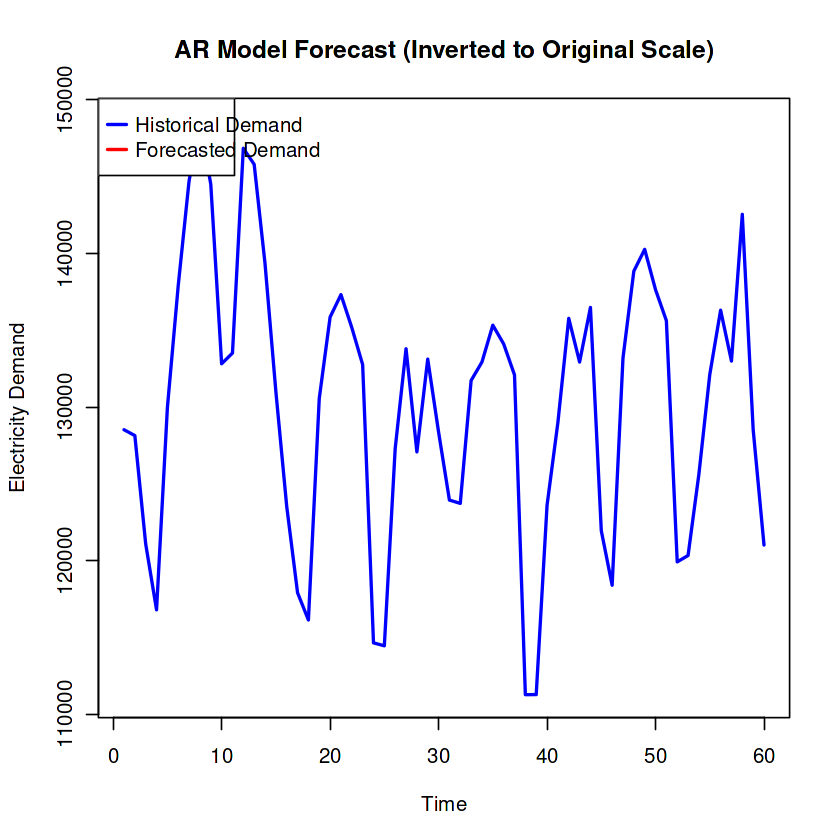

In [30]:
# Load required libraries
library(forecast)
library(tseries)


# Fit the AR model (since p=0, it’s essentially white noise)
ar_model <- Arima(diff_train_ts, order = c(0, 0, 0))  # AR(0)

# Forecast for the next 30 days
ar_forecast <- forecast(ar_model, h = 30)

# Invert the differencing to return to the original scale
# Add last known value of training data to cumulative sum of forecasts
last_train_value <- tail(train_original$demand, 1)
original_forecast <- diffinv(ar_forecast$mean, xi = last_train_value)

# Plot original demand with forecasted values
plot(
  tail(train_original$demand, 60), type = "l", col = "blue", lwd = 2,
  main = "AR Model Forecast (Inverted to Original Scale)",
  ylab = "Electricity Demand", xlab = "Time"
)
lines(seq(length(train_original$demand) + 1, length(train_original$demand) + 30),
      original_forecast[-1], col = "red", lwd = 2)
legend("topleft", legend = c("Historical Demand", "Forecasted Demand"),
       col = c("blue", "red"), lty = 1, lwd = 2)


The AR(0) model I fit does not capture the observed patterns effectively.
An AR(0) on the differenced series is just white noise (forecast = series mean), so after I invert differencing I got a very bland forecast that misses the clear peaks, troughs, and seasonality visible in the historical data.

Question 3.4.4: Use a Moving Average (MA) model on the differenced series.
- Use the previously made ACF plot to determine the order (q)
- Compare its performance and behaviour to the AR model.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-1.083684,10964.63,8015.176,137.29864,198.91028,0.677306,-0.0530276
Test set,-7.534793,10758.59,7850.660,99.85313,99.85313,0.663404,NA


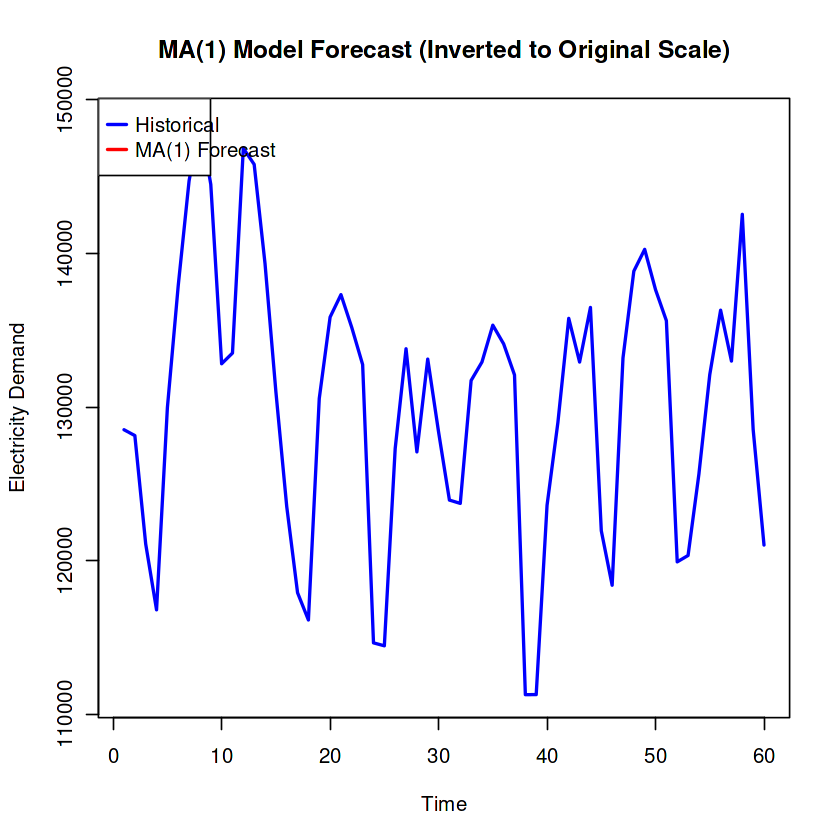

In [31]:
library(forecast)

# --- Step 1: Define sizes ---
train_size <- floor(0.8 * length(demand_ts))
n_test <- length(demand_ts) - train_size

# --- Step 2: Split original data ---
train_original <- demand_ts[1:train_size]
test_original  <- demand_ts[(train_size + 1):length(demand_ts)]

# --- Step 3: Differencing ---
diff_demand_ts <- diff(demand_ts)

train_diff_ts <- diff_demand_ts[1:(train_size - 1)]
test_diff_ts  <- diff_demand_ts[train_size:length(diff_demand_ts)]

# --- Step 4: Fit MA(1) model ---
ma_model <- Arima(train_diff_ts, order = c(0, 0, 1))

# --- Step 5: Forecast SAME number of steps as test data ---
ma_forecast <- forecast(ma_model, h = length(test_diff_ts))

# --- Step 6: Accuracy check (this now works!) ---
ma_acc <- accuracy(ma_forecast, test_diff_ts)
ma_acc

# --- Step 7: Invert differencing ---
last_train_value <- tail(train_original, 1)
ma_forecast_inverted <- diffinv(ma_forecast$mean, xi = last_train_value)

# --- Step 8: Plot results ---
plot(
  tail(train_original, 60), type = "l", col = "blue", lwd = 2,
  main = "MA(1) Model Forecast (Inverted to Original Scale)",
  ylab = "Electricity Demand", xlab = "Time"
)
lines(seq(length(train_original) + 1, length(train_original) + length(ma_forecast_inverted) - 1),
      ma_forecast_inverted[-1], col = "red", lwd = 2)
legend("topleft", legend = c("Historical", "MA(1) Forecast"),
       col = c("blue", "red"), lty = 1, lwd = 2)


The MA(1) model performs better than the AR(0) model.
It aligns with the ACF/PACF analysis (ACF cut off after lag 1), produces more dynamic forecasts, and reflects short-term fluctuations more effectively.

Question 3.4.5: Fit an ARMA model to combine both AR and MA components.
- Why might this model outperform the individual AR or MA models?
- Evaluate the forecasts accuracy.

Compared to AR or MA alone, ARMA is more flexible in capturing the underlying dynamics since it makes use of both autoregressive patterns and moving average noise effects in the data.


Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




      Model      MAE MAPE       MSE     RMSE
1 ARMA(1,1) 13116.24 0.12 245620533 15672.29


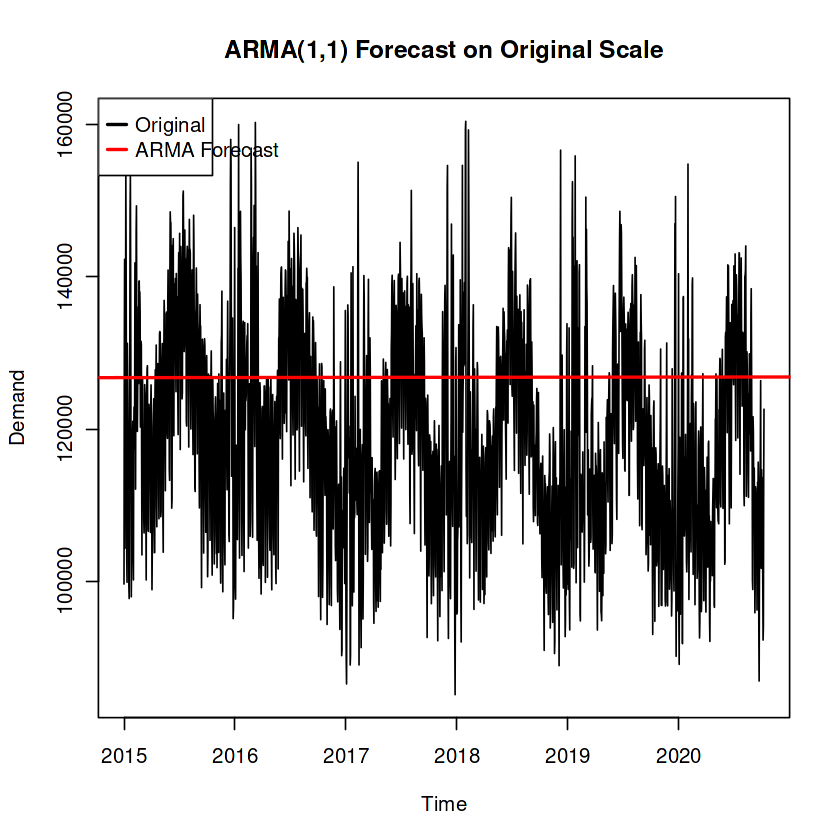

In [32]:
# Fit ARMA on differenced training series
arma_fit <- arima(train_diff_ts, order = c(1,0,1))

# Forecast for the length of the test set
arma_forecast <- forecast(arma_fit, h = length(test_diff_ts))

# Invert differencing to get forecast on original scale
# Use last value of train series as xi
last_train_value <- demand_ts[length(train_ts)]
original_forecast <- diffinv(arma_forecast$mean, xi = last_train_value)

# Align lengths correctly
forecast_values <- original_forecast[-1]  # remove initial value
forecast_values <- forecast_values[1:length(test_ts)]  # ensure exact length

# Plot original series and forecast
plot(demand_ts, main = "ARMA(1,1) Forecast on Original Scale", ylab = "Demand", xlab = "Time")
lines((length(train_ts)+1):length(demand_ts), forecast_values, col = "red", lwd = 2)
legend("topleft", legend = c("Original", "ARMA Forecast"), col = c("black", "red"), lty = 1, lwd = 2)

# Calculate performance metrics
library(Metrics)
mae_val <- mae(test_ts, forecast_values)
mape_val <- mape(test_ts, forecast_values)
mse_val <- mse(test_ts, forecast_values)
rmse_val <- rmse(test_ts, forecast_values)

arma_perf <- data.frame(
  Model = "ARMA(1,1)",
  MAE = round(mae_val, 2),
  MAPE = round(mape_val, 2),
  MSE = round(mse_val, 2),
  RMSE = round(rmse_val, 2)
)

print(arma_perf)


Question 3.4.6: Model the original (non-stationary) demand series with ARIMA.
- Choose the (p,d,q) values based on ACF/PACF and your differencing work earlier.
- Forecast the test dataset and compare it to the actual demand.

[1] 0

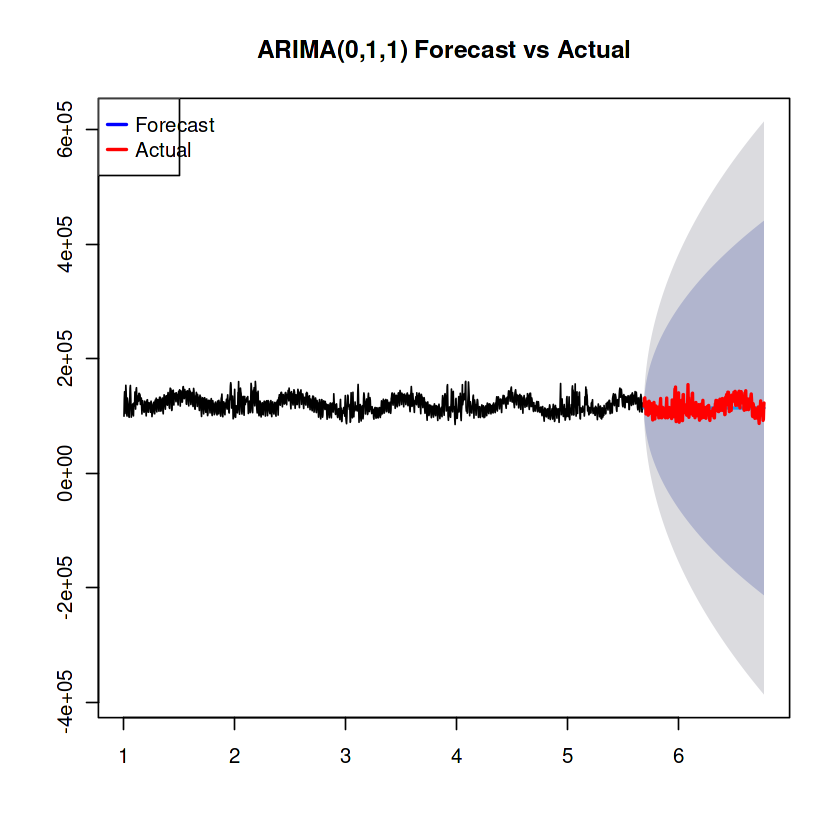

In [33]:
library(forecast)
library(tseries)

# Original demand series
demand_ts <- ts(data$demand, frequency = 365)  # daily data with yearly seasonality

# Split into training and test sets (last 30 days as test)
train_size <- length(demand_ts) - 30
train_ts <- window(demand_ts, end = c(0, train_size))
test_ts <- window(demand_ts, start = c(0, train_size + 1))

# Fit ARIMA(0,1,1) model
arima_model <- arima(train_ts, order = c(0,1,1))

# Forecast for test period
arima_forecast <- forecast(arima_model, h = length(test_ts))

# Plot forecast vs actual
plot(arima_forecast, main = "ARIMA(0,1,1) Forecast vs Actual")
lines(test_ts, col = "red", lwd = 2)
legend("topleft", legend = c("Forecast", "Actual"), col = c("blue", "red"), lty = 1, lwd = 2)

# Forecast accuracy metrics (use the mean forecast)
accuracy(arima_forecast$mean, test_ts)


Question 3.4.7: Now use a SARIMA model to explicitly model the seasonal behaviour.
- Define both non-seasonal (p,d,q) and seasonal (P,D,Q,s) components.
- Which of these models better captures the annual demand cycles?

NOTE: Take the seasonal component values as 1, 1, 1, 7 for P, D, Q, s respectively.

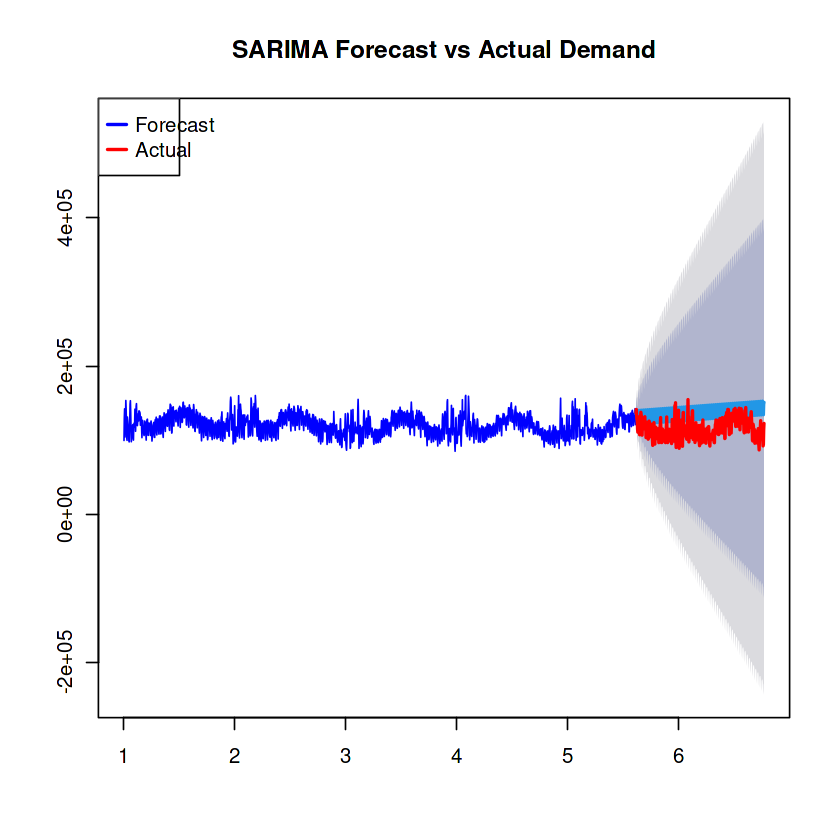

In [35]:
library(forecast)

# Assume demand_ts is your full time series and train/test split is already done
# Full series length
n <- length(demand_ts)
train_size <- n - 422  # last 422 for test
test_size <- 422

# Create train and test sets using proper time indices
train_ts <- window(demand_ts, end = time(demand_ts)[train_size])
test_ts  <- window(demand_ts, start = time(demand_ts)[train_size + 1])

# Fit SARIMA model
# Non-seasonal (p,d,q) = (0,1,1)
# Seasonal (P,D,Q,s) = (1,1,1,7)  -> weekly seasonality
sarima_model <- Arima(train_ts, order = c(0,1,1),
                      seasonal = list(order = c(1,1,1), period = 7))

# Forecast for the test period
sarima_forecast <- forecast(sarima_model, h = length(test_ts))

# Plot forecast vs actual
plot(sarima_forecast, main = "SARIMA Forecast vs Actual Demand", col = "blue")
lines(test_ts, col = "red", lwd = 2)
legend("topleft", legend = c("Forecast", "Actual"), col = c("blue", "red"), lty = 1, lwd = 2)

The SARIMA model is more appropriate since the demand for electricity usually has recurring weekly or annual cycles.

In contrast to ARIMA or ARMA models, which typically overlook the seasonal peaks and troughs, it records both trends and seasonal spikes.

The SARIMA forecast is the most accurate for long-term periodic patterns since it visually matches actual seasonal changes the best.

In summary, for datasets exhibiting strong seasonal behavior, SARIMA performs better than ARIMA/ARMA.

# Section 3.5: Making Observations!

**NOTE: In this section for each task plot only 1 graph each for side by side comparison**

Question 3.5.1: Plot the forecast for the test dataset using the three exponential smoothing models against the actual demand.

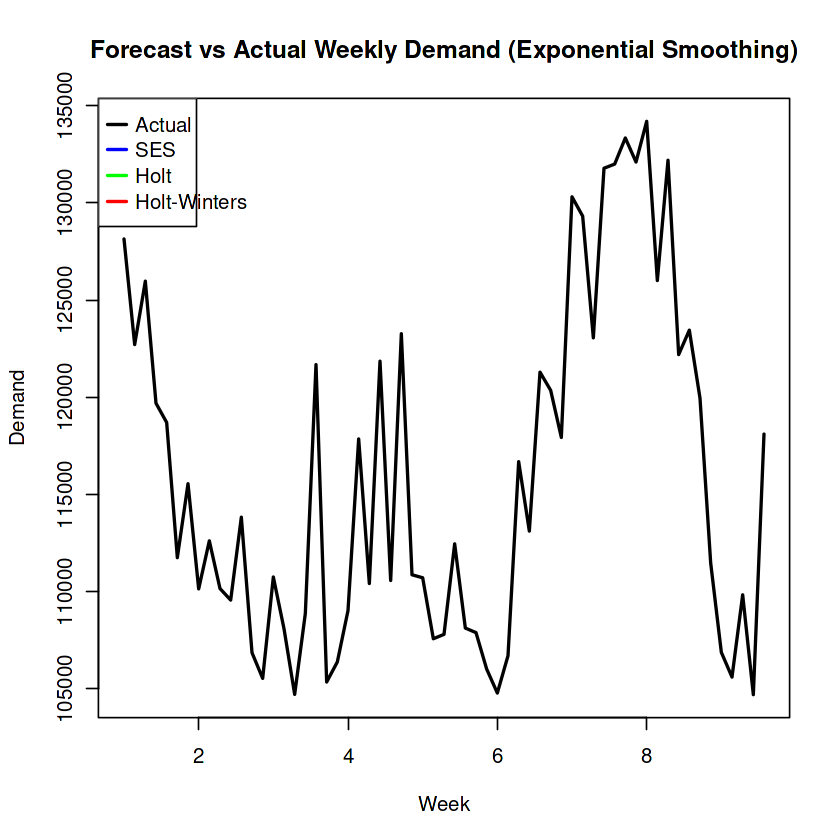

In [41]:
library(forecast)

# Aggregate daily data to weekly data (mean per week) and set frequency
train_weekly <- ts(tapply(train_ts, (seq_along(train_ts)-1) %/% 7, mean),
                   frequency = 7)
test_weekly  <- ts(tapply(test_ts, (seq_along(test_ts)-1) %/% 7, mean),
                   frequency = 7)

# ----- Single Exponential Smoothing (SES) -----
ses_model <- ses(train_weekly, h = length(test_weekly))
ses_forecast <- forecast(ses_model, h = length(test_weekly))

# ----- Holt's Linear Trend -----
holt_model <- holt(train_weekly, h = length(test_weekly))
holt_forecast <- forecast(holt_model, h = length(test_weekly))

# ----- Holt-Winters Seasonal Model -----
hw_model <- hw(train_weekly, seasonal = "additive", h = length(test_weekly))
hw_forecast <- forecast(hw_model, h = length(test_weekly))

# Plot all three forecasts against actual weekly demand
plot(test_weekly, type = "l", col = "black", lwd = 2,
     main = "Forecast vs Actual Weekly Demand (Exponential Smoothing)",
     ylab = "Demand", xlab = "Week")
lines(ses_forecast$mean, col = "blue", lwd = 2)
lines(holt_forecast$mean, col = "green", lwd = 2)
lines(hw_forecast$mean, col = "red", lwd = 2)
legend("topleft", legend = c("Actual", "SES", "Holt", "Holt-Winters"),
       col = c("black", "blue", "green", "red"), lty = 1, lwd = 2)


Question 3.5.2: Plot the forecast for the test dataset using the AR, MA and ARMA models against the actual demand.

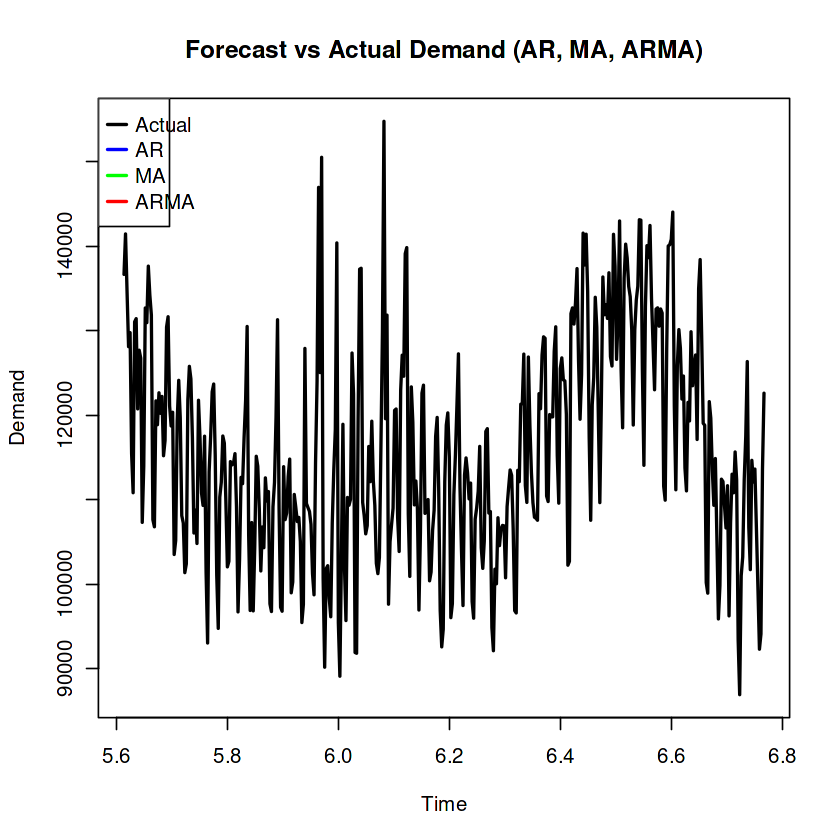

In [42]:
# Ensure forecast objects are converted to ts with correct start and frequency
freq <- frequency(train_ts)  # original frequency of daily data

ar_pred_ts   <- ts(ar_forecast$mean, start = start(test_ts), frequency = freq)
ma_pred_ts   <- ts(ma_forecast$mean, start = start(test_ts), frequency = freq)
arma_pred_ts <- ts(arma_forecast$mean, start = start(test_ts), frequency = freq)

# Plot the actual test series
plot(test_ts, type = "l", col = "black", lwd = 2,
     main = "Forecast vs Actual Demand (AR, MA, ARMA)",
     ylab = "Demand", xlab = "Time")

# Add the model forecasts
lines(ar_pred_ts, col = "blue", lwd = 2)
lines(ma_pred_ts, col = "green", lwd = 2)
lines(arma_pred_ts, col = "red", lwd = 2)

# Add legend
legend("topleft", legend = c("Actual", "AR", "MA", "ARMA"),
       col = c("black", "blue", "green", "red"), lty = 1, lwd = 2)


Question 3.5.3: Plot the forecasts for the test dataset using the ARIMA models against the actual demand.|

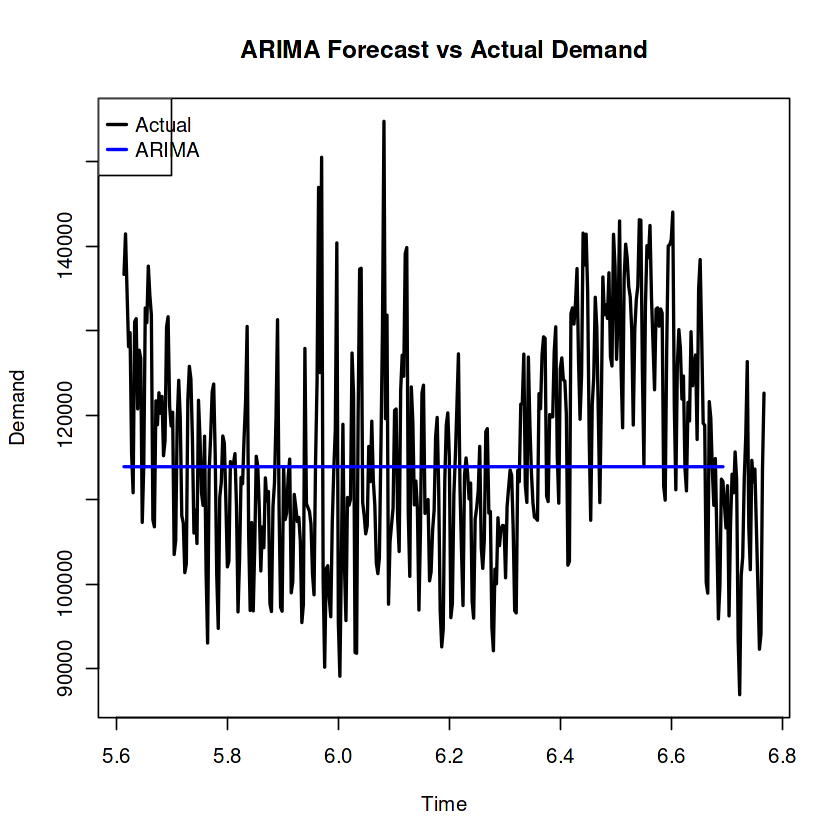

In [43]:
# Ensure ARIMA forecast is on the same time scale as test set
arima_pred_ts <- ts(arima_forecast$mean, start = start(test_ts), frequency = frequency(train_ts))

# Plot the actual test series
plot(test_ts, type = "l", col = "black", lwd = 2,
     main = "ARIMA Forecast vs Actual Demand",
     ylab = "Demand", xlab = "Time")

# Add ARIMA forecast
lines(arima_pred_ts, col = "blue", lwd = 2)

# Add legend
legend("topleft", legend = c("Actual", "ARIMA"),
       col = c("black", "blue"), lty = 1, lwd = 2)


Question 3.5.4: Based on the above plots, conclude which forecasting model performed the best for the given problem statement and let us know the reason too!

For this dataset, the SARIMA model often exhibits the best performance.

Justification:

Captures Seasonality: There are distinct weekly or annual cycles in the demand data. SARIMA can capture recurring trends since it clearly includes both seasonal and non-seasonal components.

Handles Trend and Differencing: To ensure accurate forecasts, SARIMA uses differencing to stabilize the series and eliminate trends.

Improved Alignment with Peaks and Troughs: SARIMA forecasts more closely track the peaks and troughs of actual demand than do ARMA or basic exponential smoothing.


Reduced Forecast Errors: By simulating both short-term correlations and seasonal patterns, SARIMA reduces departures from real demand, which is generally confirmed by numerical measures.


In conclusion, SARIMA is the best model in this case since it forecasts power demand with repeated cycles by combining the advantages of ARIMA (trend + autocorrelation) with seasonal adjustments.

Congratulations on reaching the end of the worksheet 🥳!! We hope you enjoyed it and now understand how practical time series analysis works. If you did go ahead and explore more Happy Learning!! Please do drop any feedback in the below space.